# Minimum feedback arc set by generalized extremal optimization (GEO) and simulated annealing (SA)

Zeqian Li
Dec 10, 2019

In [60]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
from heuristic_problems import *
from graph import *

## 0. Load datasets to graph

In [62]:
# Note that self edges (present in ER and yeast network (self-regulatory genes)) and double edges are removed.

# ER random graph; N=100
print("Loading ER...")
er=np.loadtxt("data/er.txt").astype(int)
er_names=np.arange(100)
n_er=100
g_er=DirectedGraph(n_node=n_er,edges=er).reduced_graph()

# foodweb; N=128
print("Loading foodweb...")
foodweb=np.loadtxt("data/florida.txt")[:,[0,1]].astype(int)-1 
foodweb_names=np.loadtxt("data/florida_names.txt",dtype=str,delimiter="\"")[:,1]
n_foodweb=128
g_foodweb=DirectedGraph(n_node=n_foodweb,edges=foodweb).reduced_graph()

# yeast; N=2361
# This is feed-forward! This graph may be undirected
print("Loading yeast...")
yeast=np.loadtxt("data/yeast.txt")[:,[0,1]].astype(int)-1 
yeast_names=np.loadtxt("data/yeast_names.txt",dtype=str,delimiter="\"")[:,1]
yeast_names_long=np.loadtxt("data/yeast_names_full.txt",dtype=str,delimiter="\"")[:,1]
n_yeast=2361
g_yeast=DirectedGraph(n_node=n_yeast,edges=yeast).reduced_graph()

for name,g in zip(["ER",'foodweb','yeast'],[g_er,g_foodweb,g_yeast]):
    print("%s: n_node=%d, n_edge=%d" % (name,g.n_node,len(g.edges)))


Loading ER...
Loading foodweb...
Loading yeast...
ER: n_node=100, n_edge=481
foodweb: n_node=128, n_edge=2044
yeast: n_node=2361, n_edge=6646


## 1. Generalized extremal optimization

In [63]:
def GEO(g,inspect=10,tau=1.4,epoch=100):
    ts=np.arange(epoch*len(g.edges),dtype=int)+1
    energies=np.zeros(len(ts)+1)

    fas=MinimumFeedbackArc(g)
    energies[0]=fas.energy

    print("tau=%.5f" % tau)
    probs=(np.arange(len(fas.graph.edges))+1).astype(float)**(-tau)

    min_energy=fas.energy
    min_h=fas.h.copy()
    min_h_of_node=fas.h_of_node.copy()
    min_fas_ind=fas.fas_ind.copy()

    def normalize(arr):
        return arr/np.sum(arr)

    def rankdata(arr,small_to_large=True):
        if small_to_large:
            return np.argsort(np.argsort(arr))
        else:
            return len(arr)-np.argsort(np.argsort(arr))-1

    for t in ts:
        if t % (inspect*len(fas.graph.edges))==0:
            print("t=%d, e=%d, min_e=%d" % (t/len(fas.graph.edges),fas.energy,min_energy) )
        fas_edges=fas.graph.edges[fas.fas_ind]
        
        if len(fas_edges)==0:
            print("Graph is feed-forward!")
            return
        # Select from all FAS. This is unnecessary and slows the algorithm down. To be improved in the future.
        es=[fas.calculate_energy_change(p,c,move_parent=bool(t%2)) for p,c in fas_edges]
        ranks=rankdata(es,small_to_large=True)
        p,c=fas_edges[np.random.choice(len(fas_edges),p=normalize(probs[ranks]))]

        step=MinimumFeedbackArc.FASStep(p,c,floor0=False,move_parent=True)
        fas.make_local_step(step)

        if fas.energy<min_energy:
            min_energy=fas.energy
            min_h=fas.h.copy()
            min_h_of_node=fas.h_of_node.copy()
            min_fas_ind=fas.fas_ind.copy()

        fas_edges=fas.graph.edges[fas.fas_ind]
        
        if len(fas_edges)==0:
            print("Graph is feed-forward!")
            return
        nodes_candidates,es=np.unique(fas_edges[:,1], return_counts=True)  
        _rank=rankdata(es,small_to_large=False) # large to small
        c=np.random.choice(nodes_candidates,p=normalize(probs[_rank]))
        p=fas.graph.parents_of[c][np.argmax(fas.h_of_node[fas.graph.parents_of[c]])]
        step=MinimumFeedbackArc.FASStep(p,c,floor0=False,move_parent=True)
        fas.make_local_step(step)

        if fas.energy<min_energy:
            min_energy=fas.energy
            min_h=fas.h.copy()
            min_h_of_node=fas.h_of_node.copy()
            min_fas_ind=fas.fas_ind.copy()
        energies[t]=fas.energy

    print("min_e=%d" % min_energy)
    
    return fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind

In [64]:
epoch=100
inspect=int(epoch/10)
fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind=GEO(g_er,tau=1.4,epoch=epoch,inspect=inspect)

tau=1.40000
t=10, e=158, min_e=137
t=20, e=157, min_e=124
t=30, e=164, min_e=124
t=40, e=149, min_e=124
t=50, e=168, min_e=124
t=60, e=171, min_e=124
t=70, e=156, min_e=124
t=80, e=151, min_e=124
t=90, e=170, min_e=124
t=100, e=146, min_e=124
min_e=124


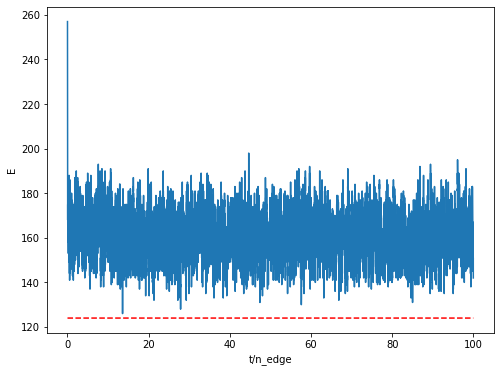

In [65]:
# Plot

plt.figure(figsize=(8,6))
xs=(np.arange(len(energies))/len(g_er.edges))
plt.plot(xs,energies)
plt.plot(xs,min_energy*np.ones(xs.shape),color='red',linestyle='--')
plt.ylabel("E")
plt.xlabel("t/n_edge")
plt.savefig("GEO-er.png")


In [52]:
epoch=10
inspect=int(epoch/10)
fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind=GEO(g_foodweb,tau=1.4,epoch=epoch,inspect=inspect)

tau=1.40000
t=2044, e=375, min_e=6
t=4088, e=23, min_e=6
t=6132, e=163, min_e=6
t=8176, e=306, min_e=6
t=10220, e=64, min_e=6
t=12264, e=10, min_e=6
t=14308, e=118, min_e=6
t=16352, e=22, min_e=6
t=18396, e=61, min_e=6
t=20440, e=193, min_e=6
min_e=6


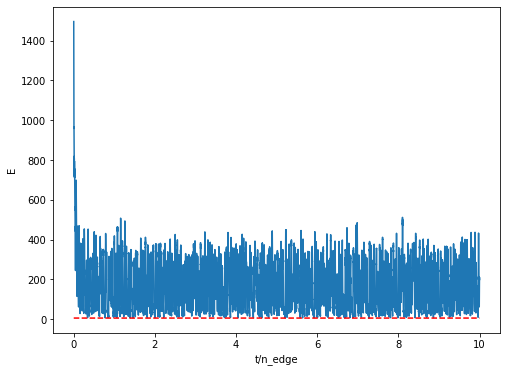

In [54]:
# Plot

plt.figure(figsize=(8,6))
xs=(np.arange(len(energies))/len(g_foodweb.edges))
plt.plot(xs,energies)
plt.plot(xs,min_energy*np.ones(xs.shape),color='red',linestyle='--')
plt.ylabel("E")
plt.xlabel("t/n_edge")
plt.savefig("GEO-foodweb.png")


## 2. Simulated annealing 

In [55]:
def SA(g,epoch=100,inspect=10,beta0=0.1):
    ts=np.arange(epoch,dtype=int)+1
    
    betas= beta0*np.log(ts)
    rejected=np.zeros(len(ts)+1,dtype=int)
    energies=[]

    fas=MinimumFeedbackArc(g)
    energies.append(fas.energy)

    min_energy=fas.energy
    min_h=fas.h.copy()
    min_h_of_node=fas.h_of_node.copy()
    min_fas_ind=fas.fas_ind.copy()

    for t,beta in zip(ts,betas):
        if t % inspect==0:
            print("t=%d, beta=%.5f, e=%d, min_e=%d" % (t,beta,fas.energy,min_energy) )
        for i in range(len(g.edges)):
            move_parent=bool(i % 2)
            step=fas.propose_step(move_parent=move_parent)
            if (step.energy_change<0 or np.random.rand()<np.exp(-beta*step.energy_change)):
                fas.make_local_step(step)
            else:
                rejected[t]+=1
            if fas.energy<min_energy:
                min_energy=fas.energy
                min_h=fas.h.copy()
                min_h_of_node=fas.h_of_node.copy()
                min_fas_ind=fas.fas_ind.copy()
            energies.append(fas.energy)
    return fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind


In [56]:
epoch=1000
inspect=int(epoch/10)
fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind=SA(g_er,beta0=0.1,epoch=epoch,inspect=inspect)

t=100, beta=0.46052, e=141, min_e=105
t=200, beta=0.52983, e=128, min_e=104
t=300, beta=0.57038, e=119, min_e=95
t=400, beta=0.59915, e=128, min_e=95
t=500, beta=0.62146, e=108, min_e=95
t=600, beta=0.63969, e=114, min_e=95
t=700, beta=0.65511, e=130, min_e=95
t=800, beta=0.66846, e=130, min_e=95
t=900, beta=0.68024, e=114, min_e=95
t=1000, beta=0.69078, e=122, min_e=95


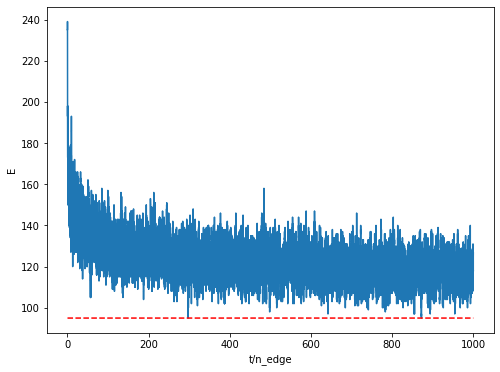

In [57]:
# Plot

plt.figure(figsize=(8,6))
xs=(np.arange(len(energies))/len(g_er.edges))
plt.plot(xs,energies)
plt.plot(xs,min_energy*np.ones(xs.shape),color='red',linestyle='--')
plt.ylabel("E")
plt.xlabel("t/n_edge")
plt.savefig("SA-er.png")


In [58]:
epoch=100
inspect=int(epoch/10)
fas,energies,min_energy,min_h,min_h_of_node,min_fas_ind=SA(g_foodweb,beta0=0.1,epoch=epoch,inspect=inspect)

t=10, beta=0.23026, e=7, min_e=6
t=20, beta=0.29957, e=7, min_e=6
t=30, beta=0.34012, e=9, min_e=6
t=40, beta=0.36889, e=8, min_e=6
t=50, beta=0.39120, e=8, min_e=6
t=60, beta=0.40943, e=7, min_e=6
t=70, beta=0.42485, e=9, min_e=6
t=80, beta=0.43820, e=8, min_e=6
t=90, beta=0.44998, e=7, min_e=6
t=100, beta=0.46052, e=8, min_e=6


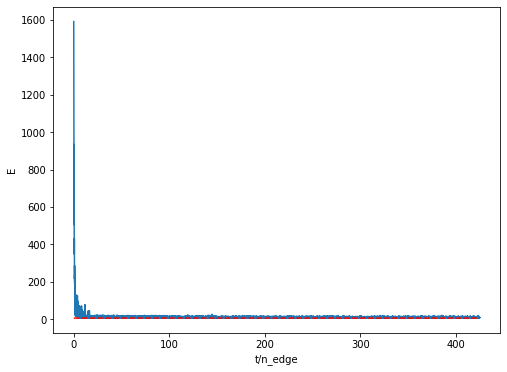

In [59]:
# Plot
plt.figure(figsize=(8,6))
xs=(np.arange(len(energies))/len(g_er.edges))
plt.plot(xs,energies)
plt.plot(xs,min_energy*np.ones(xs.shape),color='red',linestyle='--')
plt.ylabel("E")
plt.xlabel("t/n_edge")
plt.savefig("SA-foodweb.png")